<a href="https://colab.research.google.com/github/Felista-Mueni/Felista-Mueni/blob/main/Employee_Attrition_predition1_using_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#load the libraries to be used
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (confusion_matrix, f1_score, recall_score,
                             roc_auc_score, accuracy_score,auc, roc_curve )
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC,LinearSVC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#loading the datasets to be used
departments = pd.read_csv("/content/drive/MyDrive/Copy of Updated_TTSS_department.csv")
departments.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3,4,5,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ActivityDate,ID,ActivityCategoryName,StartTimeInLocal,EndTimeInLocal,FileOrUrlName,TimeSpent,isCore,ActivityTime,Description,Effective Date,JobFamilyName,DepartmentName,TeamName,DoW,Days to termination
0,2021-08-05,14906,Other,2021-08-05 08:57:48,2021-08-05 08:58:03,https://passportprd.tenent39-dns.com/ecomes.zw...,0.25,1,0.004167,0,2021-08-17,Domestic Mandatory Corporate Actions,TTSS,909,3,12
1,2021-07-20,14906,Other,2021-07-20 15:10:48,2021-07-20 15:11:03,microsoft teams,0.25,1,0.004167,0,2021-08-17,Domestic Mandatory Corporate Actions,TTSS,909,1,28
2,2021-09-01,14975,Other,2021-09-01 10:40:50,2021-09-01 10:41:05,excel,0.25,1,0.004167,0,2021-12-03,Domestic Trade Services,TTSS,1168,2,93
3,2022-01-28,14932,Other,2022-01-28 10:00:11,2022-01-28 10:00:26,microsoft teams,0.25,1,0.004167,0,2022-08-05,Income - DTC Debt,TTSS,1177,4,189
4,2021-11-30,14975,Other,2021-11-30 10:26:22,2021-11-30 10:26:52,message (html),0.50,0,0.008333,0,2021-12-03,Domestic Trade Services,TTSS,1168,1,3


In [ ]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9259123 entries, 0 to 9259122
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ActivityDate          object 
 1   ID                    int64  
 2   ActivityCategoryName  object 
 3   StartTimeInLocal      object 
 4   EndTimeInLocal        object 
 5   FileOrUrlName         object 
 6   TimeSpent             float64
 7   isCore                int64  
 8   ActivityTime          float64
 9   Description           int64  
 10  Effective Date        object 
 11  JobFamilyName         object 
 12  DepartmentName        object 
 13  TeamName              int64  
 14  DoW                   int64  
 15  Days to termination   int64  
dtypes: float64(2), int64(6), object(8)
memory usage: 1.1+ GB


In [ ]:
departments.isna().sum()

ActivityDate                  0
ID                            0
ActivityCategoryName          0
StartTimeInLocal        1282455
EndTimeInLocal          1282455
FileOrUrlName           2015558
TimeSpent               1282455
isCore                        0
ActivityTime                  0
Description                   0
Effective Date          1282455
JobFamilyName                 0
DepartmentName                0
TeamName                      0
DoW                           0
Days to termination           0
dtype: int64

In [ ]:
#drop columns Activity Date, ID, StartTimeInLocal, EndTimeInLocal, FileOrUrlName, Effective Date
departments1 = departments.drop(['ID', 'StartTimeInLocal', 'EndTimeInLocal', 'FileOrUrlName', 'Effective Date','ActivityCategoryName','JobFamilyName'], axis = 1)
departments1.isna().sum()

ActivityDate                 0
TimeSpent              1282455
isCore                       0
ActivityTime                 0
Description                  0
DepartmentName               0
TeamName                     0
DoW                          0
Days to termination          0
dtype: int64

In [ ]:
#impute the missing values in TimeSpent
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
departments1['TimeSpent'] = imp.fit_transform(departments1['TimeSpent'].values.reshape(-1, 1))

departments1.isna().sum()

ActivityDate           0
TimeSpent              0
isCore                 0
ActivityTime           0
Description            0
DepartmentName         0
TeamName               0
DoW                    0
Days to termination    0
dtype: int64

In [ ]:
print(departments1['DepartmentName'].unique())


['TTSS']


In [ ]:
def encode_dates(departments1, columns_with_prefixes):
    departments1 = departments1.copy()
    
    for column, prefix in columns_with_prefixes:
        departments1[column] = pd.to_datetime(departments1[column])
        
        departments1[prefix + '_year'] = departments1[column].apply(lambda x: x.year)
        departments1[prefix + '_month'] = departments1[column].apply(lambda x: x.month)
        departments1[prefix + '_day'] = departments1[column].apply(lambda x: x.day)
        
        departments1 = departments1.drop(column, axis=1)
        
    return departments1


def onehot_encode(departments1, columns_with_prefixes):
    departments1 = departments1.copy()
    
    for column, prefix in columns_with_prefixes:
        dummies = pd.get_dummies(departments1[column], prefix=prefix)
        departments1 = pd.concat([departments1, dummies], axis=1)
        departments1 = departments1.drop(column, axis=1)
    
    return departments1


In [ ]:
def preprocess_inputs(departments1):
    departments1 = departments1.copy()
   
   # Date encoding
date_columns = [
        ('ActivityDate', "ACD")
    ]
departments1 = encode_dates(departments1, columns_with_prefixes=date_columns)

In [ ]:
from sklearn import preprocessing

In [ ]:
le = preprocessing.LabelEncoder()
departments1['DepartmentName'] = le.fit_transform(departments1.DepartmentName.values)

In [ ]:
departments1.head()

,TimeSpent,isCore,ActivityTime,Description,DepartmentName,TeamName,DoW,Days to termination,ACD_year,ACD_month,ACD_day
0,0.25,1,0.004167,0,0,909,3,12,2021,8,5
1,0.25,1,0.004167,0,0,909,1,28,2021,7,20
2,0.25,1,0.004167,0,0,1168,2,93,2021,9,1
3,0.25,1,0.004167,0,0,1177,4,189,2022,1,28
4,0.50,0,0.008333,0,0,1168,1,3,2021,11,30


In [ ]:
#check the info of the department1 
departments1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9259123 entries, 0 to 9259122
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   TimeSpent            float64
 1   isCore               int64  
 2   ActivityTime         float64
 3   Description          int64  
 4   DepartmentName       int64  
 5   TeamName             int64  
 6   DoW                  int64  
 7   Days to termination  int64  
 8   ACD_year             int64  
 9   ACD_month            int64  
 10  ACD_day              int64  
dtypes: float64(2), int64(9)
memory usage: 777.1 MB


In [ ]:
# check information on departments1 dataset
departments1.shape

(9259123, 11)

There are now 9259123 rows and 11 columns in our new dataset departments1

# **Data cleaning**

In [ ]:
#check the missing values in departments dataset
departments1.isna().sum()

TimeSpent              0
isCore                 0
ActivityTime           0
Description            0
DepartmentName         0
TeamName               0
DoW                    0
Days to termination    0
ACD_year               0
ACD_month              0
ACD_day                0
dtype: int64

No missing values in the departments1 dataset

# **Exploratory Analysis**

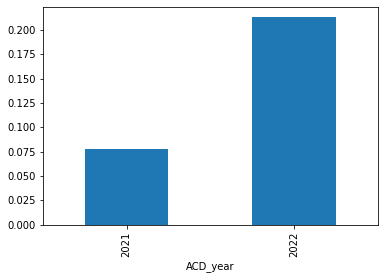

In [ ]:
# My first hypothesis is that employee attrition will increase as years go by
#Let us try to verify our hypothesis using the actual data.
#So let’s look at the yearly employee  count by depatment
departments1.groupby('ACD_year')['Description'].mean().plot.bar()

We see an slight growth in the employees attrition with respect to year which validates our hypothesis.


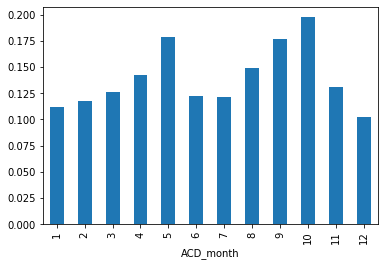

In [ ]:
departments1.groupby('ACD_month')['Description'].mean().plot.bar()

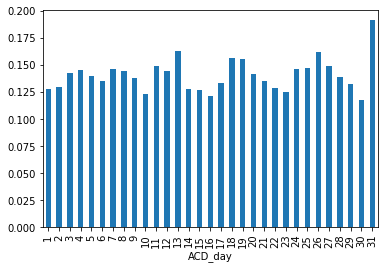

In [ ]:
departments1.groupby('ACD_day')['Description'].mean().plot.bar()

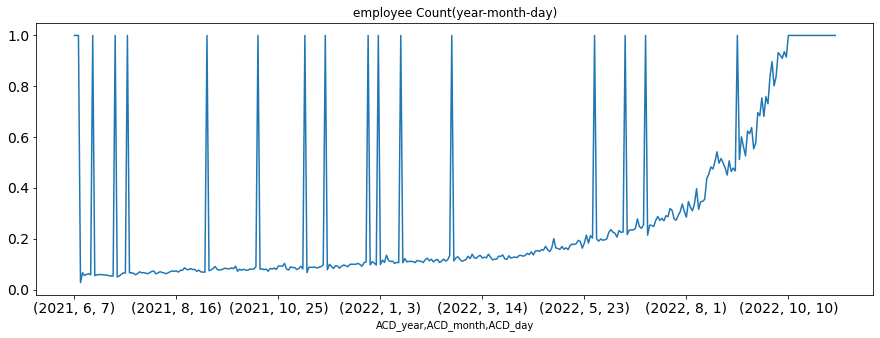

In [ ]:
temp=departments1.groupby(['ACD_year','ACD_month','ACD_day'])['Description'].mean() 
temp.plot(figsize=(15,5), title= 'employee Count(year-month-day)', fontsize=14)

In [ ]:
print(departments1.ACD_year.unique()) 
print(departments1.ACD_month.unique())  
print(departments1.ACD_day.unique())  

[2021 2022]
[ 8  7  9  1 11 10  2  6 12  3  5  4]
[ 5 20  1 28 30 18 24  4 23  8 14 19  9 15 10 16  6 17  3 27 31 12 29  7
 13 11 26 22 21 25  2]


we have only two years ie 2021 and 2022
the months range from january to december and the days from first to 31st

# **Modeling Techniques and Evaluation**

In [ ]:
# Segregating the target from our data
X = departments1.drop('Description',axis = 1).values
y = departments1['Description'].values

print(X.shape)
print(y.shape)

(9259123, 10)
(9259123,)


In [ ]:
#  Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 

# **Fitting the Model**

In [ ]:
# Let's now build the svm model 
model = SVC(kernel = 'linear')
# Train the model using the training set
model.fit(X_train,y_train)

# Predict the response for the test set
y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
# Now that we have trained our model, let's test how well it can predict the employee attrition
# Checking the accurancy of the model
model_accuracy = accuracy_score(y_test,y_pred)
model_accuracy

1.0

In [ ]:
# importing relevant libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# For further evaluation you can also check the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[1595384,       0],
       [      0,  256441]])

In [ ]:
#print classification report
classification_report(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1595384
           1       1.00      1.00      1.00    256441

    accuracy                           1.00   1851825
   macro avg       1.00      1.00      1.00   1851825
weighted avg       1.00      1.00      1.00   1851825



The model is overfitting so there is need to do hyperparameter tuning

# Hyperparameter tuning using GridSearchCv 

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['sigmoid']}

In [ ]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [ ]:
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
